In [1]:
%matplotlib inline

In [30]:
if True:
    import matplotlib.pylab as plt
    import numpy as np
    import matplotlib as mpl
    from matplotlib.pylab import plot, pcolor, imshow
    from matplotlib import animation

def _blit_draw(self, artists, bg_cache):
    # Handles blitted drawing, which renders only the artists given instead
    # of the entire figure.
    updated_ax = []
    for a in artists:
        # If we haven't cached the background for this axes object, do
        # so now. This might not always be reliable, but it's an attempt
        # to automate the process.
        if a.axes not in bg_cache:
            # bg_cache[a.axes] = a.figure.canvas.copy_from_bbox(a.axes.bbox)
            # change here
            bg_cache[a.axes] = a.figure.canvas.copy_from_bbox(a.axes.figure.bbox)
        a.axes.draw_artist(a)
        updated_ax.append(a.axes)

    # After rendering all the needed artists, blit each axes individually.
    for ax in set(updated_ax):
        # and here
        # ax.figure.canvas.blit(ax.bbox)
        ax.figure.canvas.blit(ax.figure.bbox)

# MONKEY PATCH!!
animation.Animation._blit_draw = _blit_draw


In [31]:
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))


In [32]:
def myfloat(b):
    try: 
        b = float(b)
    except ValueError:
        b = float(b.split('-')[0])*10**(-float(b.split('-')[1]))
    return b

## Grid setup


In [33]:
dryin = []
for line in open("dryin.dat", 'r'):
    dryin.append(line)
    
ncol = 94
nrow = 63
kbeg = [0]
kend = [0]
for line in range(324, 324+ncol):
    a = dryin[line].strip().split(" ")
    a = [int(x) for x in
         a if x]
    kbeg.append(a[1])
    kend.append(a[2])
    
kbeg.append(kbeg[-1])
kend.append(kend[-1])

In [34]:
# from grid
coords = []
for line in open("coords", 'r'):
    item = line.rstrip()  # strip off newline and any other trailing whitespace
    coords.append(line)
    
npt, ne = [int(j) for j in coords[0].split()]
x = np.zeros(npt + 1)
y = np.zeros(npt + 1)
z = np.zeros(npt + 1)
for i in range(1, npt + 1):
    x[i], y[i], z[i] = [float(l) for l in coords[i].split()]

global nop
nop = np.zeros([ncol + 1, nrow + 1, 4], dtype=int)
count = 0
for j in range(1, ncol + 1):
    for k in range(kbeg[j], kend[j] + 1):
        nop[j, k, :] = [int(l) for l in coords[count + 1 + npt].split()]
        count += 1
        

In [35]:
xc = np.zeros([ncol + 2, nrow + 2])  # coordinates of cell centers
yc = np.zeros([ncol + 2, nrow + 2])
zc = np.zeros([ncol + 2, nrow + 2])

for j   in range(1, ncol + 1):  # Compute grid metrics
    for k in range(kbeg[j], kend[j] + 1):
        n1 = nop[j, k, 0]
        n2 = nop[j, k, 1]
        n3 = nop[j, k, 2]
        n4 = nop[j, k, 3]
        xc[j, k] = 0.25 * (x[n1] + x[n2] + x[n3] + x[n4])
        yc[j, k] = 0.25 * (y[n1] + y[n2] + y[n3] + y[n4])
        zc[j, k] = 0.25 * (z[n1] + z[n2] + z[n3] + z[n4])

In [36]:
slope = (np.max(z) - np.min(z))/(np.max(y) - np.min(y))*100
slope

0.74074074074074081

In [37]:
t = []
itp = []  #  print step
it = []   #  time step
f =  open("output/time.out", 'r')
f.next()
for line in f:
        a = (line.strip().split(" "))
        a = [b for b in a if b]
        t.append(float(a[0]))
        itp.append(int(a[1]))
        it.append(int(a[2]))

ntstep = len(itp)
print ntstep

277


In [2]:
# tmax = t[-1]
# dt = (t[-1] - t[-2])/(it[-1] - it[-2])
# hnorm = 0.4

In [39]:
h = []
hdum =  np.zeros([ncol+2, nrow+2])

for line in open("output/h.out", 'r'):
    a = (line.strip().split(" "))
    a = [float(b) for b in a if b]
    try:
        j = int(a[0])
        k = int(a[1])
        hdum[j,k] = a[2] 
    except IndexError:
        dumt = int(a[0])
        h.append(hdum.copy())

h = np.array(h)
if len(h)!= ntstep:
    print "wrong shape"

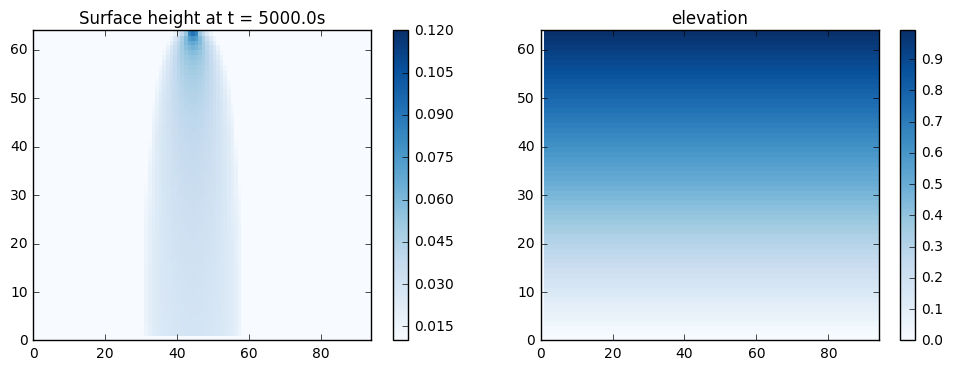

In [61]:
## plot last time step
fig = plt.figure(figsize = (12, 4))
tdum = ntstep - 1
plt.subplot(121)
plt.pcolor( h[tdum].T, cmap = 'Blues',
           norm =  mpl.colors.Normalize(vmin=0.01,vmax=0.12))
plt.xlim(0, 94); plt.ylim(0, 64)
plt.colorbar()
plt.title("Surface height at t = {0}s".format(t[tdum]))
plt.subplot(122)
plt.title('elevation')
plt.pcolor( zc.T, cmap = 'Blues' )
plt.xlim(0, 94); plt.ylim(0, 64)
plt.colorbar()
fig.savefig('plots/open_h({0:.0f}s).pdf'.format( tmax))

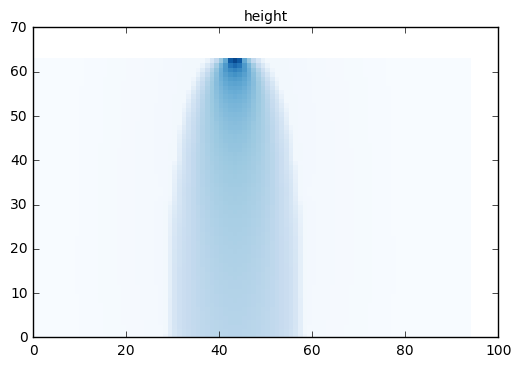

In [58]:
fig = plt.figure();
ims = []

plt.pcolor( h[-1, 1:-1, 1:-1].T, cmap = 'Blues', norm=plt.Normalize(0, .1))
plt.title('height', fontsize = 10 )
for add in np.arange(ntstep):
    ims.append((plt.pcolor( h[add, 1:-1, 1:-1].T, 
                           cmap = 'Blues', norm=plt.Normalize(0, .1)), ))

h_ani = animation.ArtistAnimation(fig, ims, interval=100, repeat_delay=3000,
                                   blit=True)



In [59]:
h_ani.save('plots/h slope={0:.1f}% tmax={1:.0f}s.mp4'.format(slope,tmax))

In [60]:
display_animation(h_ani)

In [52]:
f = []
ts = []
fdum = np.zeros([ncol+1 ]) 

for line in open("output/fluxes.out", 'r'):
    a = (line.strip().split(" "))
    try:
        a = [str(b) for b in a if b]        
        j = int(a[0])
        k = int(a[1])
        fdum[j] = a[2]   
    except ValueError:
        dumt = int(a[0])
        ts.append(float(a[1]))
        f.append(fdum.copy())
f = np.array(f)
ts = np.array(ts)
nfstep = len(f)      

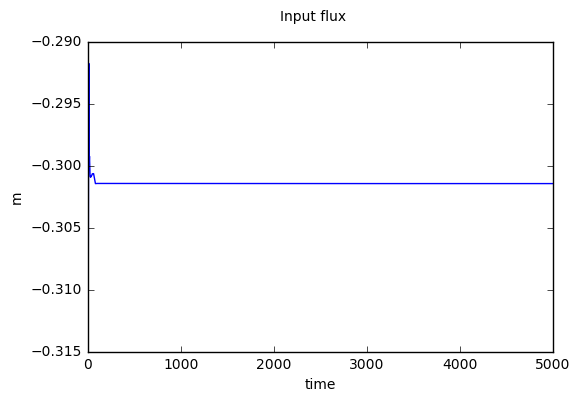

In [53]:
plt.plot(t, f.sum(1))
plt.suptitle('Input flux')
plt.xlabel('time'); plt.ylabel('m')

In [56]:
fig=plt.figure()
xx = np.arange(95)
ax = plt.axes(xlim=(0, 94), ylim=(np.min(f)-0.01, .01))
img, = plt.plot(xx, f[0])
ttl = ax.set_title('',animated=True)
# ttl = ax.text(.25, 1.05, '', transform = ax.transAxes, va='center')

ax.xaxis.set_animated(True)

def init():
    ttl.set_text('') 
    img.set_data([0],[0])
    return img, ttl, ax.xaxis

def func(n):
    ttl.set_text('flux ($hv$) along top boundary;  t={0:.1f}s'.format(t[n]))    
    img.set_data(xx, f[n])
    ax.set_xlim(xx[0],xx[-1])
    return img, ttl, ax.xaxis

ani = animation.FuncAnimation(fig,func,init_func=init,frames=len(f),
                              interval=100,blit=True)


ani.save('plots/flux slope={0:.1f}% tmax={1:.0f}s.mp4'.format(slope,tmax))
display_animation(ani)

In [57]:
ani.save('animations/flux slope={0:.1f}% tmax={1:.0f}s.mp4'.format(slope,tmax))

IOError: Error saving animation to file (cause: [Errno 32] Broken pipe) Stdout:  StdError: . It may help to re-run with --verbose-debug.